# Predicting Cryptocurrency price using LSTM

## Get data
We will use the `get_data.py` script that is prepared to get data from a given crypto since given date

In [1]:
!python3 get_data.py --crypto-name BTC --start-date 2014-1-1 --save-path btc-usd_data.parquet

BTC
[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2014-09-17  465.864014  468.174011  ...  457.334015  21056800
2014-09-18  456.859985  456.859985  ...  424.440002  34483200
2014-09-19  424.102997  427.834991  ...  394.795990  37919700
2014-09-20  394.673004  423.295990  ...  408.903992  36863600
2014-09-21  408.084991  412.425995  ...  398.821014  26580100

[5 rows x 6 columns]


## Load data

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_parquet("data/btc-usd_data.parquet")
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-05-10,63055.191406,63446.742188,60208.781250,60792.777344,60792.777344,27804954694
2024-05-11,60793.355469,61451.152344,60492.625000,60793.710938,60793.710938,13842272968
2024-05-12,60793.503906,61818.156250,60632.601562,61448.394531,61448.394531,13800459405


## Split data

We are going to use data between 2014 and 2022 for training and between 2022 and 2023 for testing

In [4]:
train = data[:"2022"]["Close"]
test = data["2022":"2023"]["Close"]

In [35]:
train

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2022-12-27    16717.173828
2022-12-28    16552.572266
2022-12-29    16642.341797
2022-12-30    16602.585938
2022-12-31    16547.496094
Name: Close, Length: 3028, dtype: float64

In [5]:
test

Date
2022-01-01    47686.812500
2022-01-02    47345.218750
2022-01-03    46458.117188
2022-01-04    45897.574219
2022-01-05    43569.003906
                  ...     
2023-12-27    43442.855469
2023-12-28    42627.855469
2023-12-29    42099.402344
2023-12-30    42156.902344
2023-12-31    42265.187500
Name: Close, Length: 730, dtype: float64

## Preprocess data

### Scale to 0-1 range

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

In [8]:
train_scaled

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.24431741],
       [0.24372746],
       [0.24290997]])

In [9]:
train_scaled.min(), train_scaled.max()

(0.0, 1.0)

### Generate batches of N days

In [10]:
prediction_days = 60

X_train, y_train = [], []

for x in range(prediction_days, len(train_scaled)):
    X_train.append(train_scaled[x-prediction_days:x, 0])
    y_train.append(train_scaled[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [20]:
X_train.shape

(2968, 60, 1)

## Create the model

In [64]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

model = Sequential()

model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse",
              metrics=["mse", "mae"])

In [65]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 60, 32)            4352      
                                                                 
 dropout_34 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_45 (LSTM)              (None, 60, 32)            8320      
                                                                 
 dropout_35 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_46 (LSTM)              (None, 60, 32)            8320      
                                                                 
 dropout_36 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_47 (LSTM)              (None, 32)              

In [66]:
history1 = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
93/93 [==============================] - 13s 25ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0568
Epoch 2/100
93/93 [==============================] - 2s 22ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0319
Epoch 3/100
93/93 [==============================] - 2s 23ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0287
Epoch 4/100
93/93 [==============================] - 2s 23ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0291
Epoch 5/100
93/93 [==============================] - 2s 23ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0294
Epoch 6/100
93/93 [==============================] - 2s 23ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0271
Epoch 7/100
93/93 [==============================] - 2s 23ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0270
Epoch 8/100
93/93 [==============================] - 2s 23ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0271
Epoch 9/100
93/93 [==============================] - 12s 126ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0255
Epoch 10/100
93/

## Test model

### Generate test batches

In [67]:
test_scaled = scaler.transform(test.values.reshape(-1, 1))

prediction_days = 60

X_test, y_test = [], []

for x in range(prediction_days, len(test_scaled)):
    X_test.append(test_scaled[x-prediction_days:x, 0])
    y_test.append(test_scaled[x, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [68]:
prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

21/21 [==============================] - 2s 17ms/step


In [69]:
prediction.shape, y_true.shape

((670, 1), (670, 1))

In [70]:
dates = test.iloc[60:]

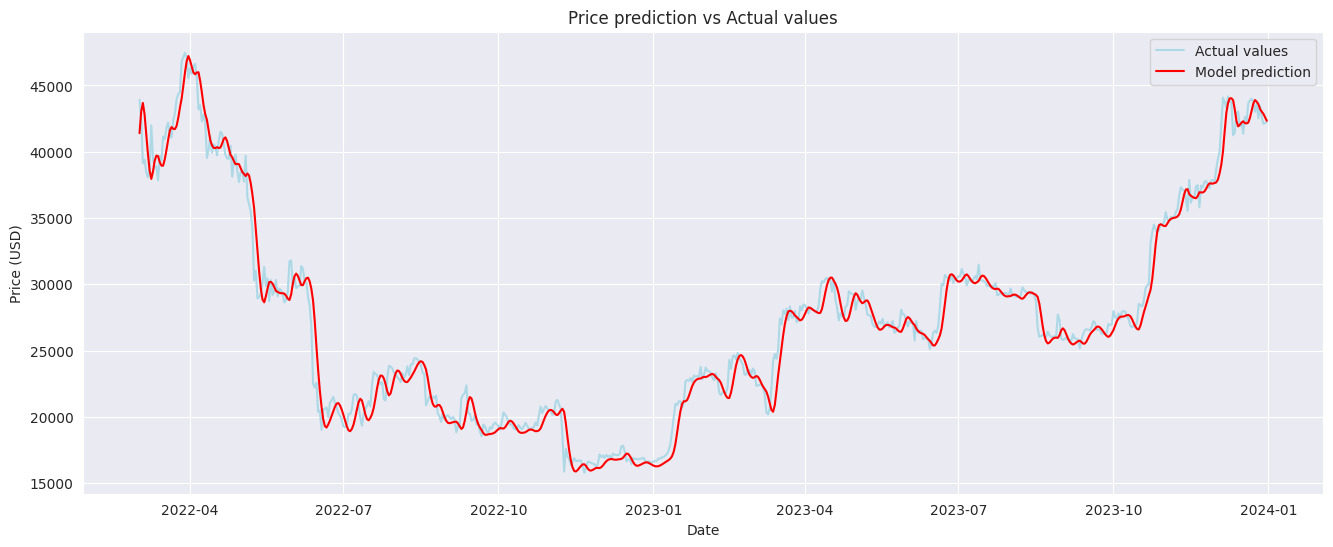

In [71]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,6))
plt.plot(dates.index.date, y_true, label="Actual values", c="lightblue")
plt.plot(dates.index.date, prediction, label="Model prediction", c="red")
plt.title("Price prediction vs Actual values")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()